In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
path = os.getcwd()
base_dir = path.split("da_case_studies")[0]

# Set the location of your data directory
data_dir = base_dir + "da_data_repo"

# location folders
os.chdir('C:\second year winter')

# Import the prewritten helper functions
####################################################
# Import packages
####################################################
import numpy as np
import copy
import pandas as pd
from plotnine import *


####################################################
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start, stop, by, round_n=3):
    return [round(x, round_n) for x in list(np.arange(start, stop, by))]


def skew(l, round_n=3):
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

def create_calibration_plot(
    data,
    file_name,
    prob_var,
    actual_var,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    plot = (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(
            color=color[0],
            size=1,
            alpha=0.7,
            show_legend=False,
            na_rm=True,
        )
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )

    return plot


def poly(x, degree=1):
    """
    Fit Polynomial
    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)

In [3]:
data = pd.read_csv("first attempt clean.csv")


In [4]:
data.describe()


,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
count,19036.0,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,19036.000000,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,...,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,1.903600e+04,19036.000000,19036.000000,19036.000000,19036.000000
mean,2012.0,1.529275e+11,9.274374e+03,9.914862e+04,8.567028e+04,418.017165,1.641894e+03,1.220200e+03,1.451590e+05,5.869079e+03,...,0.004150,0.145619,0.267388,0.627548,0.135900,1.225573e+01,0.038926,0.021538,-0.048296,0.287703
std,0.0,1.377319e+11,4.975021e+04,4.377075e+05,4.202974e+05,7141.930068,3.283540e+04,3.212567e+04,1.105861e+06,1.305634e+05,...,0.064289,0.352733,0.442608,1.473032,0.342692,1.042676e+01,0.193424,0.145174,0.534214,0.602235
min,2012.0,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1418.518555,-1.740741e+02,-2.484481e+05,0.000000e+00,-1.091879e+07,...,0.000000,0.000000,0.000000,0.083333,0.000000,2.074996e-07,0.000000,0.000000,-1.500000,0.000000
25%,2012.0,2.868348e+10,1.185185e+02,3.314815e+03,3.822222e+03,0.000000,0.000000e+00,0.000000e+00,1.074074e+02,-6.519444e+03,...,0.000000,0.000000,0.000000,0.125000,0.000000,4.049695e+00,0.000000,0.000000,-0.194249,0.000654
50%,2012.0,1.142688e+11,8.814815e+02,1.146852e+04,1.485185e+04,0.000000,0.000000e+00,0.000000e+00,4.600000e+03,2.407407e+02,...,0.000000,0.000000,0.000000,0.291667,0.000000,9.767982e+00,0.000000,0.000000,0.000000,0.025531
75%,2012.0,2.556061e+11,4.070370e+03,4.023333e+04,4.803796e+04,0.000000,0.000000e+00,0.000000e+00,3.940926e+04,4.066667e+03,...,0.000000,0.000000,1.000000,0.621691,0.000000,1.754330e+01,0.000000,0.000000,0.130772,0.188141
max,2012.0,4.641050e+11,3.570863e+06,1.874527e+07,3.660118e+07,666300.000000,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,...,1.000000,1.000000,1.000000,42.118057,1.000000,4.771708e+01,1.000000,1.000000,1.500000,2.250000


In [5]:
print(data['labor_avg_mod'].head(10))

0    0.621691
1    0.458333
2    0.621691
3    1.621212
4    0.715278
5    0.152778
6    0.083333
7    0.104167
8    7.861111
9    0.166667
Name: labor_avg_mod, dtype: float64


In [6]:
print(data['curr_assets'].head(10))

0    9.629630e+03
1    2.038852e+05
2    2.222222e+01
3    1.601667e+05
4    1.999037e+05
5    1.811111e+03
6    6.166667e+03
7    3.355556e+03
8    2.406474e+06
9    1.622222e+03
Name: curr_assets, dtype: float64


In [7]:
print(data['flag_high_d1_sales_mil_log'].head(10))

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: flag_high_d1_sales_mil_log, dtype: int64


In [8]:
print(data['ceo_young'].head(10))

0    1
1    1
2    0
3    0
4    0
5    0
6    0
7    1
8    0
9    0
Name: ceo_young, dtype: int64


In [9]:
print(data['year'].head(108))

0      2012
1      2012
2      2012
3      2012
4      2012
       ... 
103    2012
104    2012
105    2012
106    2012
107    2012
Name: year, Length: 108, dtype: int64


In [10]:
# define helper function
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

In [11]:
#model building
# define variables
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

In [12]:
print(data['sales'].head(10))

0    1.203704e+03
1    1.136515e+06
2    2.785185e+03
3    4.336667e+05
4    1.297296e+05
5    6.722222e+03
6    2.609630e+04
7    2.402593e+04
8    5.389782e+06
9    1.296296e+03
Name: sales, dtype: float64


In [13]:
#target var= fast growth


In [14]:
# further financial variables 
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

In [15]:
# flag variables
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

In [16]:
#growth var
d1 = [
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

In [17]:
#Human capital related variables
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

In [18]:
#Firms history related variables

firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

In [19]:
#interactions for logit, LASSO
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

In [20]:
# Model setups
#Simple logit models
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

In [21]:
#logit+LASSO
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

In [22]:
#CART and RF (no interactions, no modified features)
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars


In [23]:
#Quick reminder about probability models
#linear probability model
ols_modelx2 = smf.ols("high_growth_firm ~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       high_growth_firm   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     361.7
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:46:09   Log-Likelihood:                -8729.3
No. Observations:               19036   AIC:                         1.750e+04
Df Residuals:                   19017   BIC:                         1.765e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.3346      0.016     21.091      0.000       0.303       0.366
C(ind2_cat)[T.27.0]         0.0408      0.017      2.342      0.019       0.007       0.075
C(ind2_cat)[T.28.0]         0.0322      0.014      2.355      0.019       0.005       0.059
C(ind2_cat)[T.29.0]         0.0020      0.025      0.080      0.937      -0.047       0.051
C(ind2_cat)[T.30.0]         0.0557      0.030      1.829      0.067      -0.004       0.115
C(ind2_cat)[T.33.0]         0.0010      0.014      0.069      0.945      -0.026       0.028
C(ind2_cat)[T.55.0]         0.0227      0.014      1.578      0.115      -0.006       0.051
C(ind2_cat)[T.56.0]        -0.0303      0.012     -2.570      0.010      -0.053      -0.007
sales_mil_log               0.0007      0.004      0.170      0.865      -0.008       0.009
sales_mil_log_sq            0.0038      0.001      5.207      0.000       0.002       0.005
d1_sales_mil_log_mod        0.3876      0.007     57.991      0.000       0.374       0.401
profit_loss_year_pl         0.0413      0.010      4.050      0.000       0.021       0.061
fixed_assets_bs             0.0050      0.009      0.546      0.585      -0.013       0.023
share_eq_bs                -0.0120      0.007     -1.696      0.090      -0.026       0.002
curr_liab_bs                0.0998      0.013      7.720      0.000       0.074       0.125
curr_liab_bs_flag_high     -0.0582      0.011     -5.061      0.000      -0.081      -0.036
curr_liab_bs_flag_error     0.0740      0.096      0.772      0.440      -0.114       0.262
age                        -0.0128      0.000    -28.621      0.000      -0.014      -0.012
foreign_management          0.0308      0.010      3.146      0.002       0.012       0.050
==============================================================================
Omnibus:                     1959.348   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2639.569
Skew:                           0.912   Prob(JB):                         0.00
Kurtosis:                       2.957   Cond. No.                         826.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [106]:
logit_modelx2 = smf.logit("high_growth_firm~" + "+".join(M2), data).fit()

Optimization terminated successfully.
         Current function value: 0.411421
         Iterations 8


In [107]:
logit_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       high_growth_firm   No. Observations:                19036
Model:                          Logit   Df Residuals:                    19017
Method:                           MLE   Df Model:                           18
Date:                Fri, 10 Mar 2023   Pseudo R-squ.:                  0.3016
Time:                        21:52:04   Log-Likelihood:                -7831.8
converged:                       True   LL-Null:                       -11214.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.7748      0.128     -6.043      0.000      -1.026      -0.524
C(ind2_cat)[T.27.0]         0.2361      0.156      1.514      0.130      -0.070       0.542
C(ind2_cat)[T.28.0]         0.2110      0.119      1.771      0.077      -0.023       0.445
C(ind2_cat)[T.29.0]         0.1069      0.207      0.515      0.606      -0.300       0.513
C(ind2_cat)[T.30.0]         0.2071      0.268      0.774      0.439      -0.317       0.731
C(ind2_cat)[T.33.0]         0.0318      0.118      0.268      0.789      -0.200       0.264
C(ind2_cat)[T.55.0]         0.2066      0.118      1.745      0.081      -0.025       0.439
C(ind2_cat)[T.56.0]        -0.1038      0.106     -0.983      0.326      -0.311       0.103
sales_mil_log               0.0057      0.033      0.177      0.860      -0.058       0.069
sales_mil_log_sq            0.0124      0.005      2.325      0.020       0.002       0.023
d1_sales_mil_log_mod        3.9983      0.084     47.879      0.000       3.835       4.162
profit_loss_year_pl         0.4276      0.074      5.787      0.000       0.283       0.572
fixed_assets_bs            -0.0098      0.066     -0.149      0.882      -0.140       0.120
share_eq_bs                -0.1059      0.051     -2.067      0.039      -0.206      -0.005
curr_liab_bs                0.5405      0.090      6.038      0.000       0.365       0.716
curr_liab_bs_flag_high     -0.2780      0.076     -3.680      0.000      -0.426      -0.130
curr_liab_bs_flag_error     0.2269      1.112      0.204      0.838      -1.953       2.407
age                        -0.1015      0.004    -28.185      0.000      -0.109      -0.094
foreign_management          0.1924      0.066      2.915      0.004       0.063       0.322
===========================================================================================
"""

In [108]:
logit_modelx2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:       high_growth_firm
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(ind2_cat)[T.27.0]         0.0317      0.021      1.514      0.130      -0.009       0.073
C(ind2_cat)[T.28.0]         0.0283      0.016      1.772      0.076      -0.003       0.060
C(ind2_cat)[T.29.0]         0.0143      0.028      0.515      0.606      -0.040       0.069
C(ind2_cat)[T.30.0]         0.0278      0.036      0.774      0.439      -0.043       0.098
C(ind2_cat)[T.33.0]         0.0043      0.016      0.268      0.789      -0.027       0.035
C(ind2_cat)[T.55.0]         0.0277      0.016      1.746      0.081      -0.003       0.059
C(ind2_cat)[T.56.0]        -0.0139      0.014     -0.983      0.326      -0.042       0.014
sales_mil_log               0.0008      0.004      0.177      0.860      -0.008       0.009
sales_mil_log_sq            0.0017      0.001      2.326      0.020       0.000       0.003
d1_sales_mil_log_mod        0.5367      0.009     62.389      0.000       0.520       0.554
profit_loss_year_pl         0.0574      0.010      5.807      0.000       0.038       0.077
fixed_assets_bs            -0.0013      0.009     -0.149      0.882      -0.019       0.016
share_eq_bs                -0.0142      0.007     -2.068      0.039      -0.028      -0.001
curr_liab_bs                0.0726      0.012      6.062      0.000       0.049       0.096
curr_liab_bs_flag_high     -0.0373      0.010     -3.685      0.000      -0.057      -0.017
curr_liab_bs_flag_error     0.0304      0.149      0.204      0.838      -0.262       0.323
age                        -0.0136      0.000    -30.247      0.000      -0.015      -0.013
foreign_management          0.0258      0.009      2.917      0.004       0.008       0.043
===========================================================================================
"""

In [24]:
#0. Separate train and holdout data
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [25]:
data_train.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
12932,2012,2.098567e+11,2012-01-01,2012-12-31,37.037037,3048.148193,1918.518555,0.000000,0.0,0.000000,...,0,1,0,0.222222,0,12.110401,0,0,0.274544,0.075375
1693,2012,3.613574e+09,2012-01-01,2012-12-31,203.703705,3314.814697,19774.074219,933.333313,0.0,-933.333313,...,0,0,1,0.236111,0,6.369263,0,0,0.098235,0.009650
8550,2012,9.219277e+10,2012-01-01,2012-12-31,6503.703613,70125.929688,83840.742188,0.000000,0.0,0.000000,...,0,0,0,0.492424,0,0.564467,0,0,-0.024100,0.000581
13398,2012,2.249098e+11,2012-01-01,2012-12-31,2455.555664,5018.518555,6011.111328,0.000000,0.0,0.000000,...,0,0,1,0.083333,0,23.352951,0,0,0.009811,0.000096
4303,2012,2.367832e+10,2012-01-01,2012-12-31,22.222221,87981.484375,81959.257812,0.000000,0.0,0.000000,...,0,0,0,0.083333,0,10.093815,1,0,-1.500000,2.250000


In [26]:
data_holdout.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
4475,2012,2.560582e+10,2012-01-01,2012-12-31,5262.962891,30170.371094,92848.148438,0.0,0.0,0.0,...,0,0,0,2.333333,0,0.490773,0,0,0.516518,0.266791
3233,2012,1.318098e+10,2012-01-01,2012-12-31,537.037048,188.888885,3081.481445,0.0,0.0,0.0,...,0,1,0,0.108333,0,22.843846,0,0,-0.345502,0.119371
4291,2012,2.345321e+10,2012-01-01,2012-11-26,0.000000,492.592590,0.000000,0.0,0.0,0.0,...,0,1,0,0.083333,0,42.572533,0,0,0.000000,0.000000
326,2012,1.466521e+08,2012-01-01,2012-12-31,262.962952,15588.888672,3970.370361,0.0,0.0,0.0,...,0,0,0,0.111111,0,13.497405,0,0,-0.117329,0.013766
15631,2012,3.096902e+11,2012-01-01,2012-12-31,43340.742188,86188.890625,16300.000000,0.0,0.0,0.0,...,0,0,0,1.037879,0,0.558513,0,0,-0.043107,0.001858


In [27]:
print("Total")
print(data["high_growth_firm"].value_counts(normalize=True))
print("Train")
print(data_train["high_growth_firm"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["high_growth_firm"].value_counts(normalize=True))

Total
0    0.724049
1    0.275951
Name: high_growth_firm, dtype: float64
Train
0    0.723798
1    0.276202
Name: high_growth_firm, dtype: float64
Holdout
0    0.725053
1    0.274947
Name: high_growth_firm, dtype: float64


In [28]:
#1.Predict probabilities with logit and Lasso with CV
#Specify 5 fold cross-validation method

In [29]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
#a) cross validate logit models
#Set up X-vars
logit_model_vars = [M1, M2, M3, M4, M5]

In [31]:
#Set up Logit model object

#No regularisation needed so setting the paremeter to very high value

C_value_logit = [1e20]

In [32]:
#y_train, X_train = patsy.dmatrices(model_equation, data_train)


In [33]:
#data_train = data_train[data_train['sale_growth'].notnull()]


In [34]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "high_growth_firm ~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )


In [35]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train: (15228, 154)
Shape of y_train: (15228, 1)


In [36]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.350477,0.338910,0.266226,0.250260,0.231866
1,0.355553,0.345018,0.265465,0.244492,0.235022
2,0.351159,0.341785,0.256949,0.261626,0.228820
3,0.346858,0.335466,0.261545,0.251470,0.237772
4,0.350279,0.336781,0.274128,0.245634,0.229061


In [37]:
#b) Logit + LASSO
model_equation = "high_growth_firm ~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

In [38]:
print(X_train)
print(model_equation)

[[ 1.          0.          0.         ... -0.          1.58980526
  -0.        ]
 [ 1.          0.          0.         ... -0.          0.20837792
  -0.        ]
 [ 1.          1.          0.         ... -0.         -0.04340152
  -0.        ]
 ...
 [ 1.          0.          0.         ... -0.86145888 -0.03137971
  -0.        ]
 [ 1.          0.          0.         ... -0.          0.14022743
  -0.        ]
 [ 1.          0.          0.         ... -0.          0.08254006
  -1.90727007]]
high_growth_firm ~sales_mil_log+sales_mil_log_sq+total_assets_bs+fixed_assets_bs+liq_assets_bs+curr_assets_bs+share_eq_bs+subscribed_cap_bs+intang_assets_bs+extra_exp_pl+extra_inc_pl+extra_profit_loss_pl+inc_bef_tax_pl+inventories_pl+material_exp_pl+profit_loss_year_pl+personnel_exp_pl+extra_profit_loss_pl_quad+inc_bef_tax_pl_quad+profit_loss_year_pl_quad+share_eq_bs_quad+extra_exp_pl_flag_high+extra_inc_pl_flag_high+inventories_pl_flag_high+material_exp_pl_flag_high+personnel_exp_pl_flag_high+curr_liab

In [39]:
#Normalise X vars for Lasso
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

In [40]:
#Set regularization parameters
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

In [41]:
#Initialize and fit Logit Lasso
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

In [42]:
#See CV-fold RMSE-s (negative brier score)
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.411772
1,0.046416,0.001768,0.325247
2,0.021544,0.003810,0.271678
3,0.010000,0.008209,0.242658
4,0.004642,0.017685,0.225357
5,0.002154,0.038101,0.214847
6,0.001000,0.082086,0.208545
7,0.000464,0.176848,0.204108
8,0.000215,0.381008,0.202209
9,0.000100,0.820856,0.201563


In [43]:
#Save best lambda's index for later use
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

In [44]:
#Extract CV test RMSE for the Lasso with best lambda
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

In [45]:
#2. AUC, Calibration Curve, Confusion Matrix, ROC
#0.Calculate AUC for folds
#first for logit
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "high_growth_firm ~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

In [46]:
#for lasso
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

In [47]:
#Put a summary frame together
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [48]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

133

In [49]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

133

In [50]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12,0.350865,0.834216
M2,19,0.339592,0.874795
M3,36,0.264863,0.966446
M4,80,0.250696,0.972877
M5,154,0.232508,0.976851
LASSO,133,0.201518,0.985141


In [51]:
#Take best model and estimate RMSE on holdout
#M4, M5 and LASSO are practically the same - go with the simplest model, M4

In [52]:
best_logit = logit_models["M4"]
model_equation = "high_growth_firm~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

In [53]:
#Best logit holdout RMSE

In [54]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["high_growth_firm"]), 3)

0.208

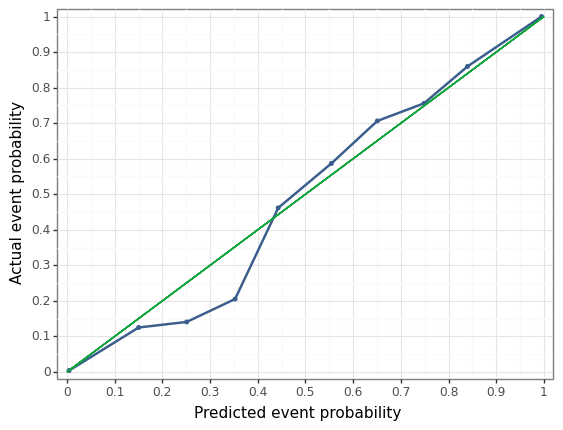

<ggplot: (115646985469)>

In [102]:
#a) Calibration curve
#how well do estimated vs actual event probabilities relate to each other?
create_calibration_plot(
    data_holdout,
    file_name="ch17-figure-1-logit-m5-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="high_growth_firm",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

In [56]:
#b) Confusion table with different tresholds
#Default: the threshold 0.5 is used to convert probabilities to binary classes
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no high_growth_firm): ", counts[0])
print(values[1], " (high_growth_firm): ", counts[1])

0.0  (no high_growth_firm):  2698
1.0  (high_growth_firm):  1110


In [99]:
cm_object1 = confusion_matrix(
    data_holdout["high_growth_firm"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual no high_growth_firm", "Actual high_growth_firm"],
    columns=["Predicted high_growth_firm", "Predicted high_growth_firm"],
)
cm1

,Predicted high_growth_firm,Predicted high_growth_firm
Actual no high_growth_firm,2617,144
Actual high_growth_firm,81,966


In [101]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["high_growth_firm"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actual no high_growth_firm", "Actual high_growth_firm"],
    columns=["Predicted no high_growth_firm", "Predicted high_growth_firm"],
)
cm1b

,Predicted no high_growth_firm,Predicted high_growth_firm
Actual no high_growth_firm,2617,144
Actual high_growth_firm,81,966


In [59]:

#A sensible choice: mean of predicted probabilities
mean_predicted_default_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_default_prob, 3)

0.276

In [60]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["high_growth_firm"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no high_growth_firm", "Actual high_growth_firm"],
    columns=["Predicted no high_growth_firm", "Predicted high_growth_firm"],
)
cm2

,Predicted no high_growth_firm,Predicted high_growth_firm
Actul no high_growth_firm,2496,265
Actual high_growth_firm,26,1021


In [61]:
#c) Visualize ROC (with thresholds in steps) on holdout
#What if we want to compare multiple thresholds?

#First, discrete ROC (with thresholds in steps) on holdout

thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["high_growth_firm"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [62]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

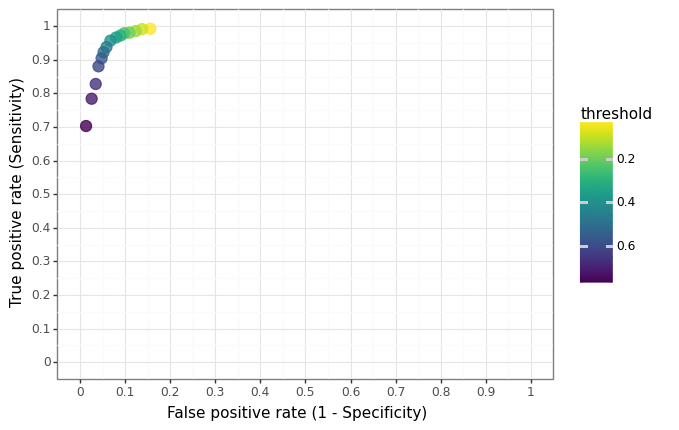

<ggplot: (115645807863)>

In [63]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

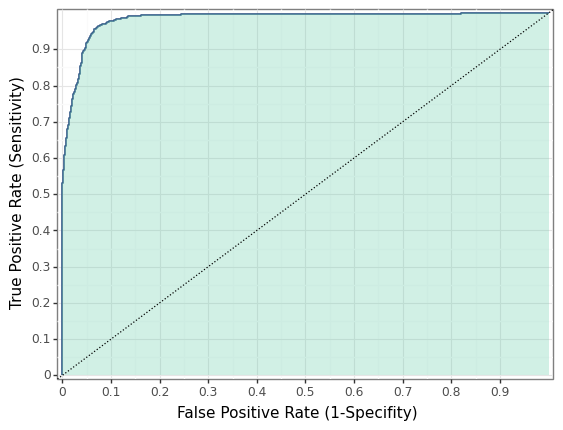

<ggplot: (115645806523)>

In [64]:
#Continuous ROC on holdout with best model
create_roc_plot(data_holdout["high_growth_firm"], data_holdout["best_logit_pred_proba"])

In [65]:
#3. We have a loss function
#Introduce loss function

#Relative cost of of a false negative classification (as compared with a false positive classification)

FP = 1
FN = 10
cost = FN / FP

In [66]:
#The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum() / len(y_train)

In [67]:
#Draw ROC Curve and find optimal threshold with loss function

#The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

#Iterate through:

#1.models
#2.Folds

best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("high_growth_firm ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["high_growth_firm"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords




In [68]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()

In [69]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.191182,0.190118,0.537495,0.540558
1,M2,0.228456,0.211220,0.426122,0.424631
2,M3,0.224419,0.231829,0.179013,0.186535
3,M4,0.224910,0.225331,0.155240,0.138588
4,M5,0.213504,0.230016,0.138364,0.122496
5,LASSO,0.177627,0.200259,0.109995,0.106404


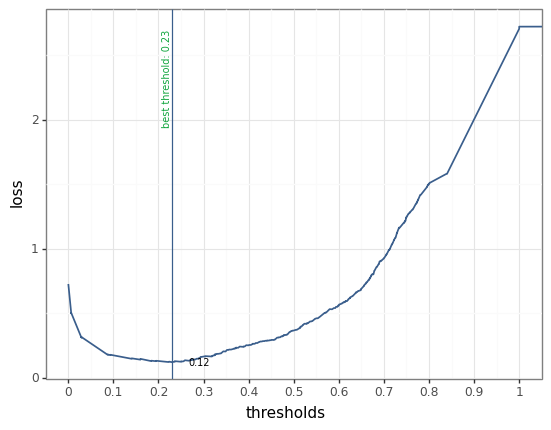

<ggplot: (115646481083)>

In [98]:
#Create loss plot based on Fold5 in CV
model_to_plot = "M5"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

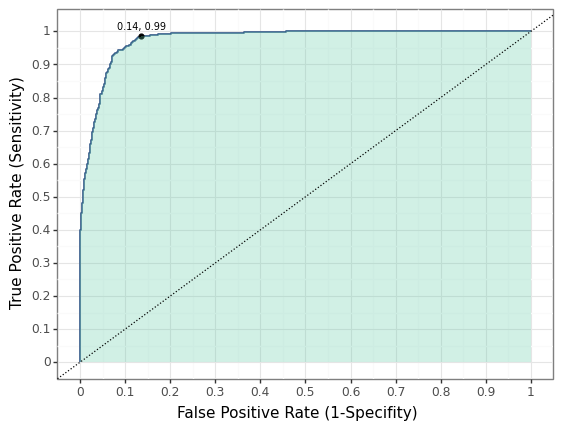

<ggplot: (115646046242)>

In [71]:
#Create roc plot plot based on Fold5 in CV
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)

In [105]:
#Let's see our chosen model, M4's holdout expected loss
best_logit_optimal_treshold = best_thresholds_cv["M5"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["high_growth_firm"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["high_growth_firm"])
round(expected_loss_holdout, 3)

0.132

In [73]:
#CM on holdout
cm_object3 = confusion_matrix(data_holdout["high_growth_firm"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no high_growth_firm", "Actual high_growth_firm"],
    columns=["Predicted no high_growth_firm", "Predicted high_growth_firm"],
)
cm3

,Predicted no high_growth_firm,Predicted high_growth_firm
Actul no high_growth_firm,2474,287
Actual high_growth_firm,22,1025


In [74]:
#PREDICTION WITH RANDOM FOREST
y_train, rfvars_train = patsy.dmatrices("high_growth_firm~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("high_growth_firm~" + "+".join(rfvars), data_holdout)

<Figure size 640x480 with 0 Axes>

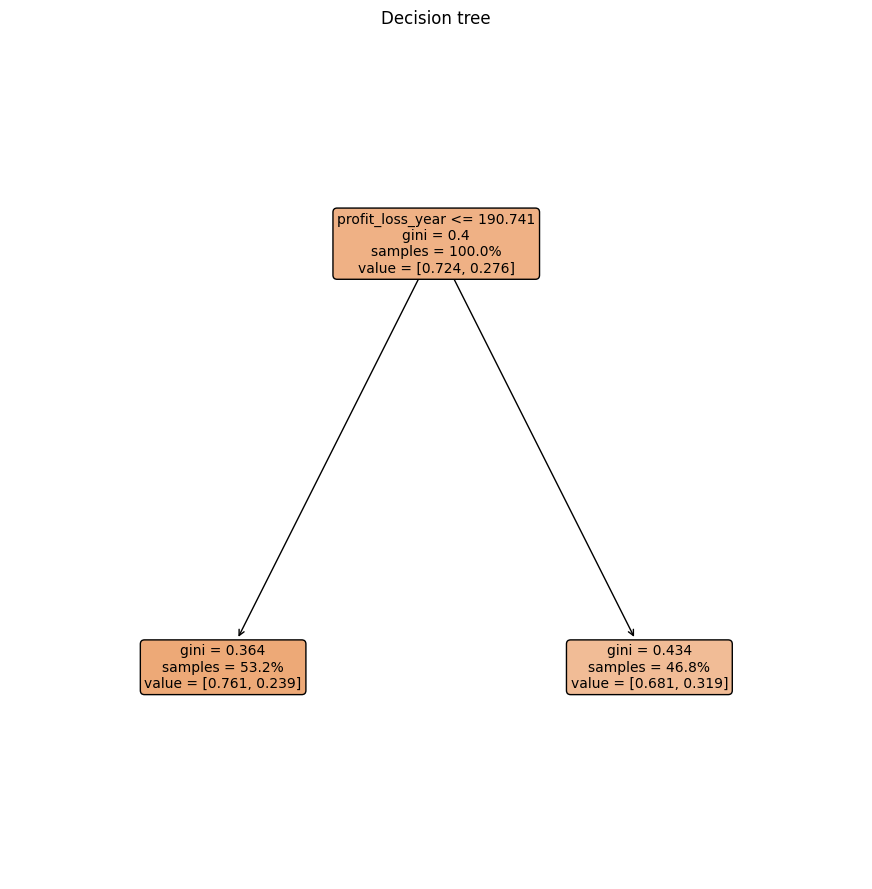

In [75]:
#Graph example for decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = data_train[["sales_mil", "profit_loss_year", "foreign_management"]]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()

In [76]:
#Probability forest
#Split by gini, ratio of 1's in each tree, average over trees
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

In [77]:
#5 fold cross validation
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [78]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [79]:
#Create CV summary table
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.989947,0.190727
1,5,16,0.989789,0.191923
2,6,11,0.990943,0.182136
3,6,16,0.990766,0.182971
4,7,11,0.991245,0.177390
5,7,16,0.991205,0.178638


In [80]:
#Obtain optimal parameter values
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 11}

In [81]:
#Get average (ie over the folds) RMSE and AUC
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [82]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12.0,0.350865,0.834216
M2,19.0,0.339592,0.874795
M3,36.0,0.264863,0.966446
M4,80.0,0.250696,0.972877
M5,154.0,0.232508,0.976851
LASSO,133.0,0.201518,0.985141
RF,n.a.,0.177390,0.991245


In [83]:
#Extract fold level RMSE and AUC
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

In [84]:
#Take a look at foldwise RMSE and AUC
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.350477,0.338910,0.266226,0.250260,0.231866,0.202945,0.177558
1,0.355553,0.345018,0.265465,0.244492,0.235022,0.208974,0.184136
2,0.351159,0.341785,0.256949,0.261626,0.228820,0.197881,0.171860
3,0.346858,0.335466,0.261545,0.251470,0.237772,0.200638,0.173823
4,0.350279,0.336781,0.274128,0.245634,0.229061,0.197154,0.179314


In [85]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.831112,0.874286,0.965856,0.972408,0.975958,0.983607,0.991444
1,0.832980,0.872833,0.966213,0.973509,0.975464,0.983435,0.989796
2,0.837046,0.872177,0.970738,0.972126,0.980459,0.987142,0.992160
3,0.841781,0.884262,0.966173,0.970796,0.973095,0.983858,0.991519
4,0.828163,0.870419,0.963248,0.975548,0.979276,0.987662,0.991305


In [86]:
#Now use loss function and search for best thresholds and expected loss over folds
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["high_growth_firm"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["high_growth_firm"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)

In [87]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)

In [88]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.177,0.991,0.175,0.134,0.062,0.078


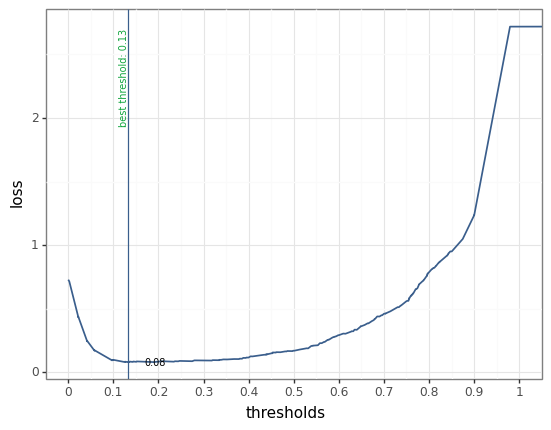

<ggplot: (115645805629)>

In [89]:
#Create plots based on Fold5 in CV
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)


In [90]:
#create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.18

In [91]:
#ROC AUC on holdout

auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.991

In [92]:
#Get expected loss on holdout

holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)

0.069

In [93]:
#Final results
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [94]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,12.0,0.350865,0.834216,0.191182,0.537495
M2,19.0,0.339592,0.874795,0.228456,0.426122
M3,36.0,0.264863,0.966446,0.224419,0.179013
M4,80.0,0.250696,0.972877,0.224910,0.155240
M5,154.0,0.232508,0.976851,0.213504,0.138364
LASSO,133.0,0.201518,0.985141,0.177627,0.109995
RF,n.a.,0.177390,0.991245,0.175203,0.062123
